# Gesture Recognition (TO BE RUN IN GOOGLE COLAB)

In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Problem Statement
Imagine we are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie


Each video is a sequence of 30 frames (or images).



In [1]:
import kagglehub
gesture_recognition_path = kagglehub.dataset_download('imsparsh/gesture-recognition')

100%|██████████| 1.60G/1.60G [00:20<00:00, 84.5MB/s]

Extracting files...


In [2]:
print(gesture_recognition_path)

/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2


In [3]:
!ls /root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2

LICENSE  README.md  train  train.csv  val  val.csv


In [4]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [5]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.18.0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train.csv').readlines())
val_doc = np.random.permutation(open('/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/val.csv').readlines())
num_classes = 5  #number of softmax classes

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train'
val_path = '/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [9]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [10]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. we have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1047: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
<ipython-input-11-57fe1ce1000b>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread("/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png")
<ipython-input-11-57fe1ce1000b>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread("/r

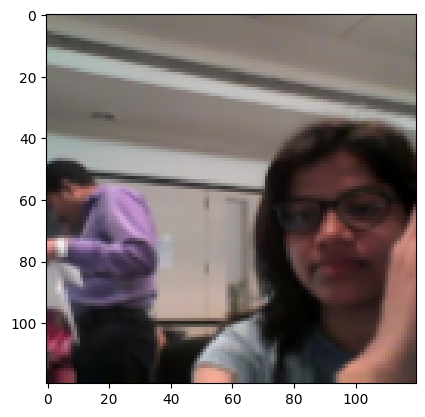

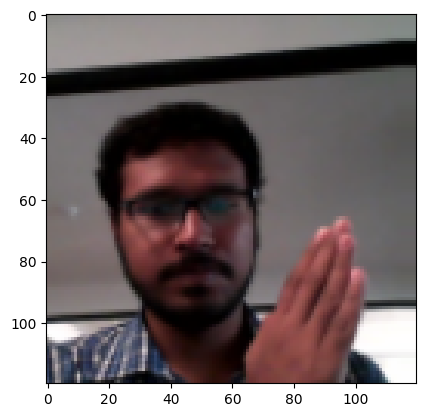

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png")
#160 by 120
image2 = imageio.imread("/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00015.png")
#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here we make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. We will Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [13]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

#### Model 1: Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [14]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 15, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 7, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 3, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 3, 15, 15, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 3, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)

<ipython-input-11-57fe1ce1000b>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 0.3393 - loss: 1.9590

<ipython-input-11-57fe1ce1000b>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3406 - loss: 1.9538
Epoch 1: val_loss improved from inf to 4.10354, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00001-1.61495-0.42685-4.10354-0.27000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - categorical_accuracy: 0.3419 - loss: 1.9489 - val_categorical_accuracy: 0.2700 - val_loss: 4.1035 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5387 - loss: 1.1807
Epoch 2: val_loss improved from 4.10354 to 3.76462, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00002-1.15822-0.55807-3.76462-0.20000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - categorical_accuracy: 0.5390 - loss: 1.1804 - val_categorical_accuracy: 0.2000 - val_loss: 3.7646 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6715 - loss: 0.9566
Epoch 3: val_loss did not improve from 3.76462
67/67 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - categorical_accuracy: 0.6716 - loss: 0.9560 - val_categorical_accuracy: 0.2300 - val_loss: 6.3965 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7049 - loss: 0.7944
Epoch 4: val_loss did not improve from 3.76462
67/67 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - categorical_accuracy: 0.7049 - loss: 0.7943 - val_categorical_accuracy: 0.2600 - val_loss: 4.7933 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6783 - loss: 0.8522
Epoch 5: val_loss improved from 3.76462 to 3.54693, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00005-0.83211-

67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - categorical_accuracy: 0.6784 - loss: 0.8519 - val_categorical_accuracy: 0.2500 - val_loss: 3.5469 - learning_rate: 0.0010
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7367 - loss: 0.6846
Epoch 6: val_loss improved from 3.54693 to 1.93743, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00006-0.72045-0.73002-1.93743-0.47000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - categorical_accuracy: 0.7366 - loss: 0.6852 - val_categorical_accuracy: 0.4700 - val_loss: 1.9374 - learning_rate: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7542 - loss: 0.6917
Epoch 7: val_loss did not improve from 1.93743
67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - categorical_accuracy: 0.7541 - loss: 0.6918 - val_categorical_accuracy: 0.3700 - val_loss: 2.2768 - learning_rate: 0.0010
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7966 - loss: 0.5410
Epoch 8: val_loss did not improve from 1.93743
67/67 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - categorical_accuracy: 0.7964 - loss: 0.5417 - val_categorical_accuracy: 0.4300 - val_loss: 2.4986 - learning_rate: 0.0010
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8294 - loss: 0.4739
Epoch 9: val_loss did not improve from 1.93743

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/6

67/67 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - categorical_accuracy: 0.8120 - loss: 0.5612 - val_categorical_accuracy: 0.6800 - val_loss: 0.9918 - learning_rate: 1.0000e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8521 - loss: 0.3979
Epoch 11: val_loss improved from 0.99175 to 0.74681, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00011-0.39082-0.85219-0.74681-0.71000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.8521 - loss: 0.3978 - val_categorical_accuracy: 0.7100 - val_loss: 0.7468 - learning_rate: 1.0000e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8555 - loss: 0.3822
Epoch 12: val_loss improved from 0.74681 to 0.59804, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00012-0.37144-0.85973-0.59804-0.79000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - categorical_accuracy: 0.8555 - loss: 0.3821 - val_categorical_accuracy: 0.7900 - val_loss: 0.5980 - learning_rate: 1.0000e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8716 - loss: 0.3281
Epoch 13: val_loss improved from 0.59804 to 0.57304, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00013-0.34187-0.88084-0.57304-0.82000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - categorical_accuracy: 0.8717 - loss: 0.3283 - val_categorical_accuracy: 0.8200 - val_loss: 0.5730 - learning_rate: 1.0000e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8670 - loss: 0.3873
Epoch 14: val_loss did not improve from 0.57304
67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - categorical_accuracy: 0.8671 - loss: 0.3870 - val_categorical_accuracy: 0.8500 - val_loss: 0.6030 - learning_rate: 1.0000e-04
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8790 - loss: 0.3208
Epoch 15: val_loss improved from 0.57304 to 0.45298, saving model to model_conv3D_1_2025-02-1404_33_41.095239/model-00015-0.31726-0.87934-0.45298-0.80000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.8790 - loss: 0.3207 - val_categorical_accuracy: 0.8000 - val_loss: 0.4530 - learning_rate: 1.0000e-04
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9009 - loss: 0.2793
Epoch 16: val_loss did not improve from 0.45298
67/67 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - categorical_accuracy: 0.9010 - loss: 0.2791 - val_categorical_accuracy: 0.7700 - val_loss: 0.6977 - learning_rate: 1.0000e-04
Epoch 17/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9250 - loss: 0.2075
Epoch 17: val_loss did not improve from 0.45298
67/67 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - categorical_accuracy: 0.9248 - loss: 0.2081 - val_categorical_accuracy: 0.8000 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 18/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9093 - loss: 0.2832
Epoch 18: val_loss improved from 0.45298 to 0.45185, saving model to model_conv3D_1_2025-02-1404_33_41.095239/mo

67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - categorical_accuracy: 0.9093 - loss: 0.2833 - val_categorical_accuracy: 0.8300 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 19/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9161 - loss: 0.2365
Epoch 19: val_loss did not improve from 0.45185
67/67 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - categorical_accuracy: 0.9161 - loss: 0.2366 - val_categorical_accuracy: 0.8300 - val_loss: 0.4759 - learning_rate: 1.0000e-04
Epoch 20/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9349 - loss: 0.2094
Epoch 20: val_loss did not improve from 0.45185
67/67 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - categorical_accuracy: 0.9347 - loss: 0.2099 - val_categorical_accuracy: 0.7700 - val_loss: 0.6130 - learning_rate: 1.0000e-04


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


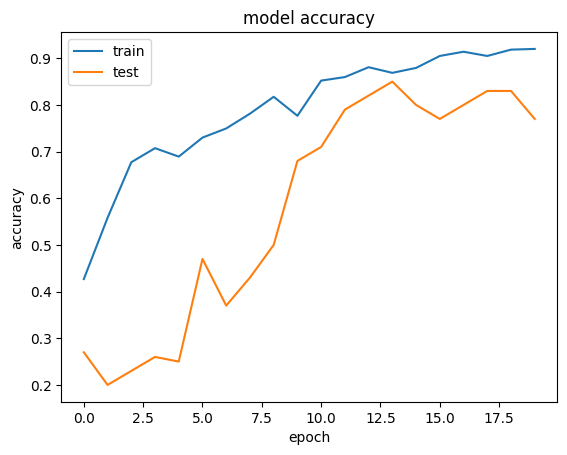

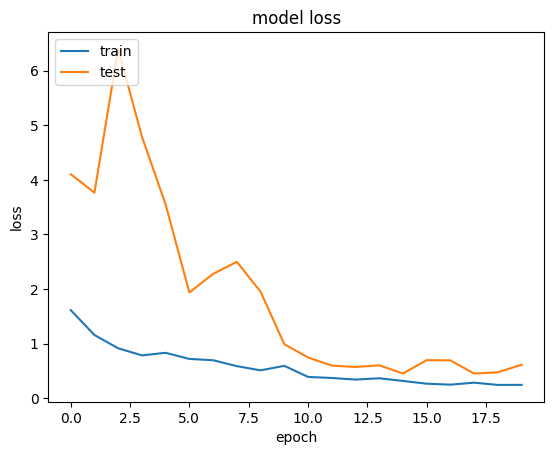

In [19]:
plot_loss_accuracy(history)

#### Model 2: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [20]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 20, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 10, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 5, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 15, 15, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

<ipython-input-11-57fe1ce1000b>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.3773 - loss: 1.7072

<ipython-input-11-57fe1ce1000b>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3783 - loss: 1.7044
Epoch 1: val_loss improved from inf to 3.07065, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00001-1.52204-0.44042-3.07065-0.16000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - categorical_accuracy: 0.3792 - loss: 1.7017 - val_categorical_accuracy: 0.1600 - val_loss: 3.0706 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5555 - loss: 1.1732
Epoch 2: val_loss did not improve from 3.07065
67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.5554 - loss: 1.1737 - val_categorical_accuracy: 0.2200 - val_loss: 3.3175 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6019 - loss: 0.9569
Epoch 3: val_loss did not improve from 3.07065
67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - categorical_accuracy: 0.6023 - loss: 0.9572 - val_categorical_accuracy: 0.2200 - val_loss: 4.6207 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6253 - loss: 1.0339
Epoch 4: val_loss did not improve from 3.07065

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/6

67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - categorical_accuracy: 0.6946 - loss: 0.8300 - val_categorical_accuracy: 0.3500 - val_loss: 2.8763 - learning_rate: 1.0000e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7519 - loss: 0.6425
Epoch 6: val_loss improved from 2.87625 to 2.54648, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00006-0.67444-0.73605-2.54648-0.29000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.7517 - loss: 0.6429 - val_categorical_accuracy: 0.2900 - val_loss: 2.5465 - learning_rate: 1.0000e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7954 - loss: 0.5860
Epoch 7: val_loss improved from 2.54648 to 1.70729, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00007-0.60505-0.77225-1.70729-0.42000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - categorical_accuracy: 0.7951 - loss: 0.5863 - val_categorical_accuracy: 0.4200 - val_loss: 1.7073 - learning_rate: 1.0000e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8089 - loss: 0.5220
Epoch 8: val_loss improved from 1.70729 to 1.59141, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00008-0.56067-0.79035-1.59141-0.42000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.8086 - loss: 0.5226 - val_categorical_accuracy: 0.4200 - val_loss: 1.5914 - learning_rate: 1.0000e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7938 - loss: 0.5392
Epoch 9: val_loss improved from 1.59141 to 1.00145, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00009-0.49222-0.80694-1.00145-0.65000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.7940 - loss: 0.5385 - val_categorical_accuracy: 0.6500 - val_loss: 1.0015 - learning_rate: 1.0000e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8022 - loss: 0.5461
Epoch 10: val_loss did not improve from 1.00145
67/67 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - categorical_accuracy: 0.8023 - loss: 0.5458 - val_categorical_accuracy: 0.6100 - val_loss: 1.1957 - learning_rate: 1.0000e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7955 - loss: 0.5017
Epoch 11: val_loss improved from 1.00145 to 0.75615, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00011-0.49580-0.80392-0.75615-0.78000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.7956 - loss: 0.5016 - val_categorical_accuracy: 0.7800 - val_loss: 0.7561 - learning_rate: 1.0000e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8307 - loss: 0.4265
Epoch 12: val_loss improved from 0.75615 to 0.62091, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00012-0.44520-0.82805-0.62091-0.82000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - categorical_accuracy: 0.8306 - loss: 0.4268 - val_categorical_accuracy: 0.8200 - val_loss: 0.6209 - learning_rate: 1.0000e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8433 - loss: 0.4445
Epoch 13: val_loss did not improve from 0.62091
67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.8435 - loss: 0.4440 - val_categorical_accuracy: 0.7600 - val_loss: 0.8234 - learning_rate: 1.0000e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8227 - loss: 0.4326
Epoch 14: val_loss did not improve from 0.62091
67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.8229 - loss: 0.4323 - val_categorical_accuracy: 0.7900 - val_loss: 0.7179 - learning_rate: 1.0000e-04
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9040 - loss: 0.3095
Epoch 15: val_loss did not improve from 0.62091

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001.
6

67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.8893 - loss: 0.2956 - val_categorical_accuracy: 0.7800 - val_loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 20/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9367 - loss: 0.2127
Epoch 20: val_loss improved from 0.60365 to 0.48135, saving model to model_conv3D_2_2025-02-1404_33_41.095239/model-00020-0.21980-0.93363-0.48135-0.79000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - categorical_accuracy: 0.9367 - loss: 0.2129 - val_categorical_accuracy: 0.7900 - val_loss: 0.4814 - learning_rate: 1.0000e-04


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


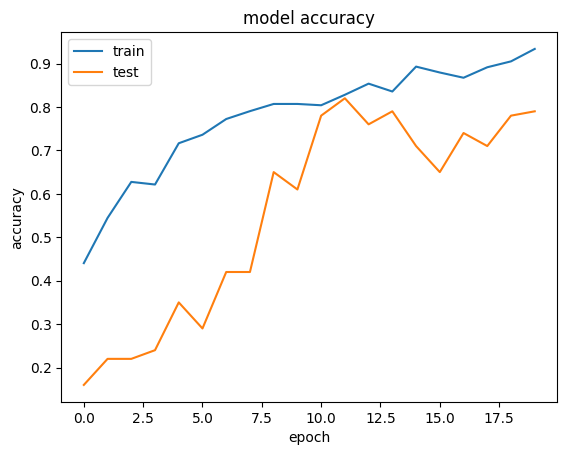

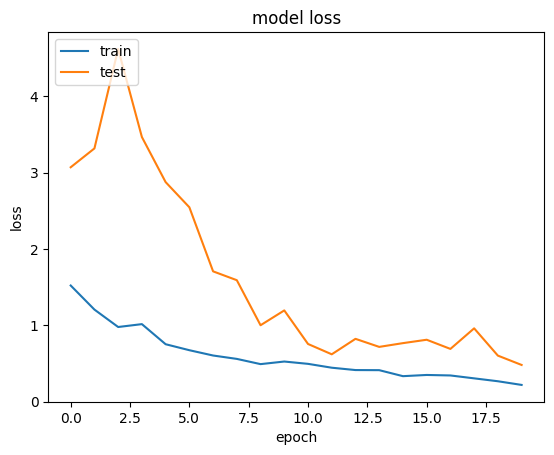

In [23]:
plot_loss_accuracy(history)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### Model 3: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [24]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,604,933 (13.75 MB)

 Trainable params: 3,603,685 (13.75 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

<ipython-input-11-57fe1ce1000b>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - categorical_accuracy: 0.8740 - loss: 0.3594

<ipython-input-11-57fe1ce1000b>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8746 - loss: 0.3579
Epoch 1: val_loss improved from 0.88195 to 0.61739, saving model to model_conv3D_3_2025-02-1404_33_41.095239/model-00001-0.30808-0.89593-0.61739-0.74000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - categorical_accuracy: 0.8749 - loss: 0.3572 - val_categorical_accuracy: 0.7400 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9174 - loss: 0.2779
Epoch 2: val_loss improved from 0.61739 to 0.51617, saving model to model_conv3D_3_2025-02-1404_33_41.095239/model-00002-0.29697-0.90498-0.51617-0.87000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.9173 - loss: 0.2782 - val_categorical_accuracy: 0.8700 - val_loss: 0.5162 - learning_rate: 1.0000e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9114 - loss: 0.2844
Epoch 3: val_loss did not improve from 0.51617
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 0.9115 - loss: 0.2842 - val_categorical_accuracy: 0.8400 - val_loss: 0.5302 - learning_rate: 1.0000e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9265 - loss: 0.2312
Epoch 4: val_loss did not improve from 0.51617
67/67 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - categorical_accuracy: 0.9261 - loss: 0.2320 - val_categorical_accuracy: 0.7500 - val_loss: 0.5759 - learning_rate: 1.0000e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8749 - loss: 0.3148
Epoch 5: val_loss improved from 0.51617 to 0.45362, saving model to model_conv3D_3_2025-02-1404_33_41.095239/model-00

67/67 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - categorical_accuracy: 0.8751 - loss: 0.3147 - val_categorical_accuracy: 0.8200 - val_loss: 0.4536 - learning_rate: 1.0000e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9007 - loss: 0.2746
Epoch 6: val_loss did not improve from 0.45362
67/67 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - categorical_accuracy: 0.9006 - loss: 0.2748 - val_categorical_accuracy: 0.8400 - val_loss: 0.4896 - learning_rate: 1.0000e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8987 - loss: 0.2995
Epoch 7: val_loss did not improve from 0.45362
67/67 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - categorical_accuracy: 0.8988 - loss: 0.2993 - val_categorical_accuracy: 0.8300 - val_loss: 0.4908 - learning_rate: 1.0000e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9190 - loss: 0.2242
Epoch 8: val_loss improved from 0.45362 to 0.43913, saving model to model_conv3D_3_2025-02-1404_33_41.095239/model-00

67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - categorical_accuracy: 0.9190 - loss: 0.2241 - val_categorical_accuracy: 0.8500 - val_loss: 0.4391 - learning_rate: 1.0000e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9209 - loss: 0.2111
Epoch 9: val_loss did not improve from 0.43913
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 0.9209 - loss: 0.2115 - val_categorical_accuracy: 0.8400 - val_loss: 0.4685 - learning_rate: 1.0000e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9517 - loss: 0.1523
Epoch 10: val_loss did not improve from 0.43913
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 0.9518 - loss: 0.1525 - val_categorical_accuracy: 0.7700 - val_loss: 0.6070 - learning_rate: 1.0000e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9381 - loss: 0.1836
Epoch 11: val_loss did not improve from 0.43913

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001.
67/

67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - categorical_accuracy: 0.9528 - loss: 0.1756 - val_categorical_accuracy: 0.8700 - val_loss: 0.4383 - learning_rate: 1.0000e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9701 - loss: 0.1246
Epoch 14: val_loss did not improve from 0.43829
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 0.9701 - loss: 0.1245 - val_categorical_accuracy: 0.7900 - val_loss: 0.5814 - learning_rate: 1.0000e-04
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9398 - loss: 0.1730
Epoch 15: val_loss did not improve from 0.43829
67/67 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - categorical_accuracy: 0.9399 - loss: 0.1729 - val_categorical_accuracy: 0.8000 - val_loss: 0.5610 - learning_rate: 1.0000e-04
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9701 - loss: 0.1443
Epoch 16: val_loss did not improve from 0.43829
67/67 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - categorical_accuracy: 

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


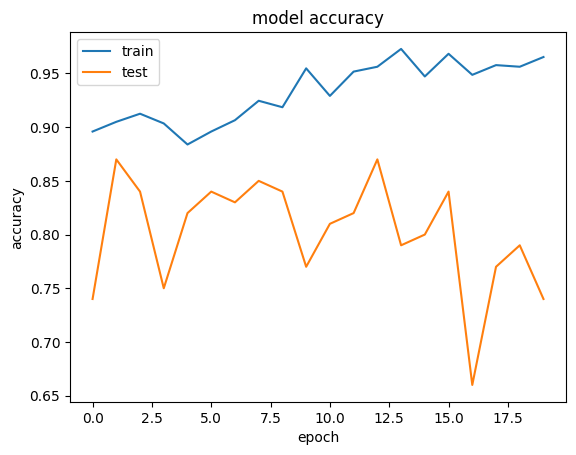

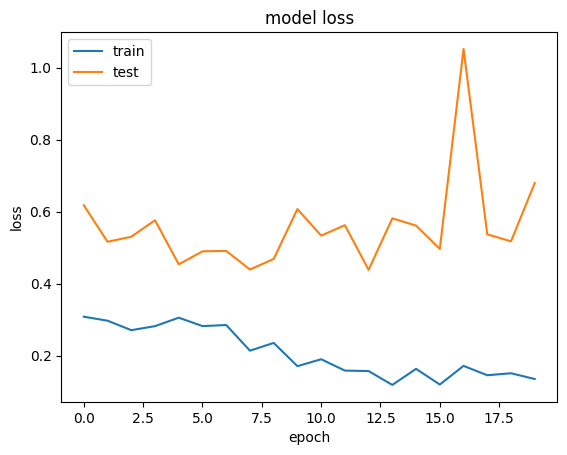

In [28]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [29]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 30, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 30, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 30, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 15, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 15, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 15, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 15, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 7, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 7, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 7, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 7, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_14 (MaxPooling3D)      │ (None, 3, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 3, 15, 15, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 3, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 3, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_15 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,933,765 (7.38 MB)

 Trainable params: 1,932,517 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


In [30]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

<ipython-input-11-57fe1ce1000b>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
66/67 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.4091 - loss: 1.8035

<ipython-input-11-57fe1ce1000b>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4097 - loss: 1.8003
Epoch 1: val_loss improved from inf to 6.31336, saving model to model_conv3D_4_2025-02-1404_33_41.095239/model-00001-1.59180-0.44646-6.31336-0.16000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - categorical_accuracy: 0.4102 - loss: 1.7973 - val_categorical_accuracy: 0.1600 - val_loss: 6.3134 - learning_rate: 0.0010
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5599 - loss: 1.1173
Epoch 2: val_loss improved from 6.31336 to 2.83676, saving model to model_conv3D_4_2025-02-1404_33_41.095239/model-00002-1.18602-0.54902-2.83676-0.27000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - categorical_accuracy: 0.5597 - loss: 1.1183 - val_categorical_accuracy: 0.2700 - val_loss: 2.8368 - learning_rate: 0.0010
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6108 - loss: 1.0588
Epoch 3: val_loss did not improve from 2.83676
67/67 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - categorical_accuracy: 0.6103 - loss: 1.0598 - val_categorical_accuracy: 0.2300 - val_loss: 3.6230 - learning_rate: 0.0010
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5961 - loss: 1.0914
Epoch 4: val_loss did not improve from 2.83676
67/67 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - categorical_accuracy: 0.5959 - loss: 1.0915 - val_categorical_accuracy: 0.2900 - val_loss: 4.5953 - learning_rate: 0.0010
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6155 - loss: 1.0012
Epoch 5: val_loss did not improve from 2.83676

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/6

67/67 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - categorical_accuracy: 0.6700 - loss: 0.8782 - val_categorical_accuracy: 0.3000 - val_loss: 2.4183 - learning_rate: 1.0000e-04
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7183 - loss: 0.7707
Epoch 7: val_loss improved from 2.41832 to 2.09648, saving model to model_conv3D_4_2025-02-1404_33_41.095239/model-00007-0.77962-0.70739-2.09648-0.34000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - categorical_accuracy: 0.7181 - loss: 0.7709 - val_categorical_accuracy: 0.3400 - val_loss: 2.0965 - learning_rate: 1.0000e-04
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6836 - loss: 0.8108
Epoch 8: val_loss did not improve from 2.09648
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - categorical_accuracy: 0.6839 - loss: 0.8100 - val_categorical_accuracy: 0.3000 - val_loss: 2.2173 - learning_rate: 1.0000e-04
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7380 - loss: 0.6917
Epoch 9: val_loss improved from 2.09648 to 1.78351, saving model to model_conv3D_4_2025-02-1404_33_41.095239/model-00009-0.65784-0.76471-1.78351-0.36000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - categorical_accuracy: 0.7384 - loss: 0.6912 - val_categorical_accuracy: 0.3600 - val_loss: 1.7835 - learning_rate: 1.0000e-04
Epoch 10/15
 8/67 ━━━━━━━━━━━━━━━━━━━━ 3:12 3s/step - categorical_accuracy: 0.6473 - loss: 0.7979

In [ ]:
plot_loss_accuracy(history)

#### Model 5: Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64)
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 6: Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

In [ ]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 7: Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

#### Model 8: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 9: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

#### Model 10: Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes




In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, initial_epoch=0)

In [ ]:
plot_loss_accuracy(history)

In [ ]:
import datetime, pytz;
print("Current Time in IST:", datetime.datetime.now(pytz.utc).astimezone(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S'))